Variational Autoencoder test

Python version: x <br>
PyTorch version: y <br>
Numpy version: z <br>

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

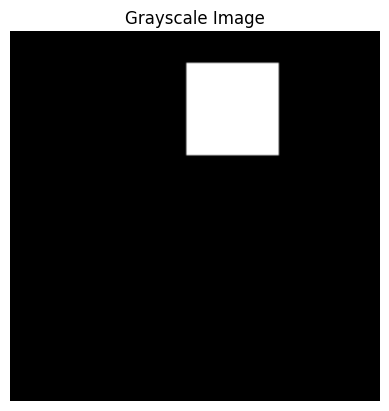

In [31]:
from typing import Tuple
import matplotlib.pyplot as plt

class RandomImageDataset(DataLoader):
    def __init__(self, num_samples: int=1024, image_size: Tuple[int, int]=(128,128), object_size: Tuple[int, int]=(32,32)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.object_size = object_size

    def __len__(self) -> int:
        return num_samples

    def __getitem__(self, idx: int):
        z = torch.zeros(self.image_size)
        o = torch.ones(self.object_size)

        object_x_min = 0
        object_x_max = self.image_size[0] - self.object_size[0]

        object_y_min = 0
        object_y_max = self.image_size[0] - self.object_size[0]

        object_x = np.random.randint(object_x_min, object_x_max)
        object_y = np.random.randint(object_y_min, object_y_max)

        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = o        
        return z

dataset_test = RandomImageDataset()
plt.imshow(dataset_test.__getitem__(123), cmap='gray')
plt.axis('off')  # Turn off axis
plt.title('Grayscale Image')
plt.show()

print()

In [ ]:
# Encoder
class Encoder(torch.nn):
    def __init__(self, input_di)):
    

In [ ]:
# Decoder